In [1]:
%matplotlib inline
from operator import itemgetter

import chembl_downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chembl_downloader import queries
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.Chem.Draw import IPythonConsole
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df = chembl_downloader.query(queries.get_assay_sql("CHEMBL3888506"))
df

,canonical_smiles,chembl_id,standard_type,standard_relation,standard_value,standard_units
0,O=C(Nc1cn(C2CCNCC2)nc1-c1cc(Cl)ccc1OC(F)F)c1cn...,CHEMBL3985468,Ki,=,0.46,nM
1,Nc1nn2cccnc2c1C(=O)Nc1cn(C2CCNCC2)nc1-c1cc(Cl)...,CHEMBL3903218,Ki,=,0.19,nM
2,CN1C[C@H]2CN(C(=O)Cn3cc(NC(=O)c4cnn5cccnc45)c(...,CHEMBL3974166,Ki,=,0.81,nM
3,O=C(Nc1cn(CC(=O)N2C[C@@H]3CNC[C@@H]3C2)nc1-c1c...,CHEMBL3931278,Ki,=,0.80,nM
4,CCN1C[C@H]2CN(C(=O)Cn3cc(NC(=O)c4cnn5cccnc45)c...,CHEMBL3899762,Ki,=,0.78,nM
...,...,...,...,...,...,...
462,CN(CCCC#N)C1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc34...,CHEMBL3959085,Ki,=,1.41,nM
463,CN(CC(C)(C)C#N)C1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cc...,CHEMBL3984319,Ki,=,0.56,nM
464,CC(C)(C#N)CNC1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cccnc...,CHEMBL3908154,Ki,=,0.74,nM
465,CN(CC1(C#N)CC1)C1CCN(C(=O)Cn2cc(NC(=O)c3cnn4cc...,CHEMBL3981690,Ki,=,0.64,nM


In [3]:
mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
sampleidx = np.random.choice(list(range(len(mols))), size=400, replace=False)
samplemols = [mols[i] for i in sampleidx]
sampleact = [9 - np.log10(df["standard_value"][idx]) for idx in sampleidx]

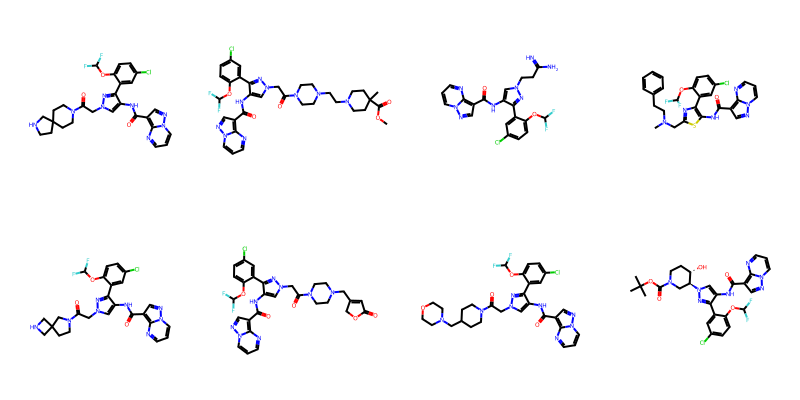

In [4]:
Draw.MolsToGridImage(samplemols[:8], molsPerRow=4, useSVG=True)

In [5]:
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in samplemols]

In [6]:
def fp2arr(fp):
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [7]:
X = np.asarray([fp2arr(fp) for fp in fps])

In [8]:
X.shape

(400, 2048)

In [9]:
# draw 60 x 60 grid space
size = 20

In [10]:
N = size * size

In [11]:
data = PCA(n_components=100).fit_transform(X.astype(np.float32))
embeddings = TSNE(init="pca", random_state=794).fit_transform(data)
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)

/Users/cthoyt/.virtualenvs/cheminf310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/cthoyt/.virtualenvs/cheminf310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


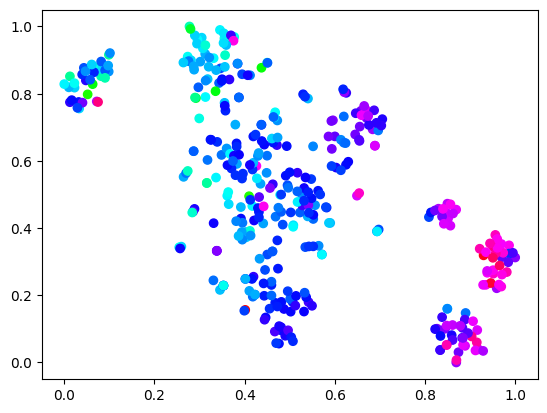

In [12]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=sampleact, cmap="hsv")
plt.show()

In [13]:
grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(
    -1, 2
)

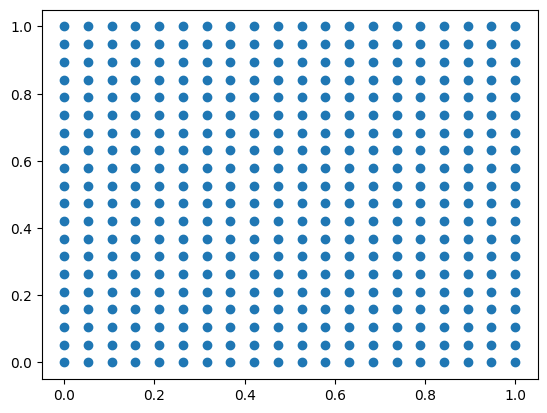

In [14]:
plt.scatter(grid[:, 0], grid[:, 1])
plt.show()

In [15]:
print(embeddings.shape)

(400, 2)


In [16]:
cost_mat = cdist(grid, embeddings, "sqeuclidean").astype(np.float32)
cost_mat2 = cost_mat * (10000 / cost_mat.max())
print(cost_mat2.shape)
print(grid.shape)

(400, 400)
(400, 2)


In [17]:
from lapjv import lapjv

ModuleNotFoundError: No module named 'lapjv'

In [ ]:
%time row_asses, col_asses, _ = lapjv(cost_mat2)

In [ ]:
grid_lap = grid[col_asses]

In [ ]:
plt.scatter(grid_lap[:, 0], grid_lap[:, 1], c=sampleact, cmap="hsv")
plt.show()